# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [1]:
!pip3 install pytorch_lightning torchmetrics


**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [1]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy as acc
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# You may add any imports you need
from torchvision.transforms import v2

In [2]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(315)

In [4]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-18 16:19:40--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-18 16:19:40--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce2ba0356c4299cec5a798622eb.dl.dropboxusercontent.com/cd/0/get/CHyRa7RpmHaN2GPTXwLK8Zu5ucb4xiiwNudqFcg79k8sYC-O9_bmzDlRjxOdqnL5uOoDNTMUyQKr1nAZO6tJbeKZc6p4hEdfuZCypR9azLtCEDnKBCOw_D6PMWlXAoBNHoXZ2a7ENPXLpWnqCHD4pSs2/file?dl=1# [following]
--2023-11-18 16:19:41--  https://uce2ba0356c4299cec5a798622eb.dl.dropboxusercontent.com/cd/0/get/CHyRa7RpmHaN2GPTXwLK8Zu5ucb4xiiwNudqFcg79k8sYC-O9_bmzDlRjxOdqnL5uOoDNTMUyQKr1nAZO6tJbeKZc6p4hEdfuZCyp

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [5]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
])



train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

In [6]:
means = torch.zeros(3)
stds = torch.zeros(3)

for inputs, _ in train_dataloader:
    means += torch.mean(inputs, dim=(0, 2, 3))
    stds += torch.std(inputs, dim=(0, 2, 3))

means /= len(train_dataloader)
stds /= len(train_dataloader)

print("Means:", means)
print("Stds:", stds)

Means: tensor([0.4802, 0.4480, 0.3975])
Stds: tensor([0.2763, 0.2687, 0.2814])


In [83]:
# YOU CAN DEFINE AUGMENTATIONS HERE
seed_everything(315)
train_transform = transforms.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2763, 0.2687, 0.2814])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2763, 0.2687, 0.2814])
])



train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)

In [8]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

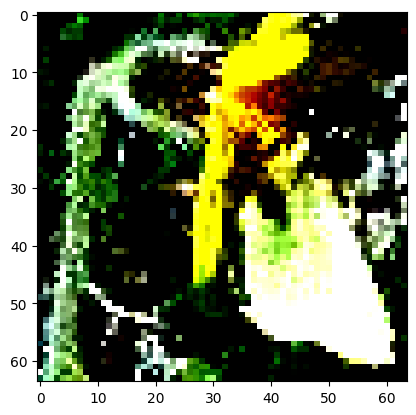

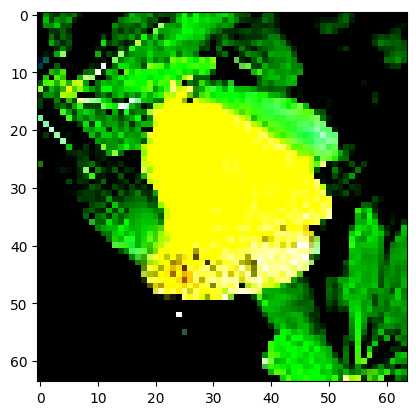

In [9]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [80]:
class MegaNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.vgg1 = torch.nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.vgg2 = torch.nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )


        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(in_features=2048, out_features=200)

        self.dropout = nn.Dropout(p=0.4)
        self.batch_norm1 = nn.BatchNorm1d(2048)


        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()


    def _forward(self, x):
        x = self.vgg1(x)
        x = self.vgg2(x)


        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.act(self.batch_norm1(x))
        x = self.dropout(x)

        return self.fc2(x)

    def forward(self, images, target=None):
        output = self._forward(images)


        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy_value = acc(self.preds.long(), self.targets.long(), task='multiclass', num_classes=200)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy_value

In [74]:
from collections import defaultdict, namedtuple

LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses", "eval_batch_losses", "eval_batch_accuracies"]
)

In [75]:
def train_epoch(model, data_loader, optimizer, return_losses=False, device="cuda:0"):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    all_losses = []
    all_accuracies = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
            all_accuracies.append(accuracy.item())

    acc = model.get_accuracy(reset=True)
    metrics = {
        "loss": total_loss / num_batches,
        "accuracy": acc,
        "batch_losses": all_losses,
        "batch_accuracies": all_accuracies
    }
    return metrics

In [76]:
def fit(model, epochs, train_data_loader, validation_data_loader, optimizer, scheduler=None, device="cuda:0"):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    all_eval_batch_losses = []
    all_eval_batch_accuracies = []

    for epoch in range(epochs):
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device,
        )
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_iterator, device=device
            )
        epoch_eval_losses.append(validation_metrics["loss"])
        all_eval_batch_losses.extend(validation_metrics["batch_losses"])
        all_eval_batch_accuracies.extend(validation_metrics["batch_accuracies"])
        if scheduler:
            scheduler.step()

    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses, all_eval_batch_losses, all_eval_batch_accuracies)

In [ ]:
seed_everything(315)
LR = 0.00045 #0.00045
EPOCHS = 18
weight_decay_value = 1e-4
mega_model = MegaNet().to(device)
lambda_func = lambda epoch: 0.9**epoch
optimizer = torch.optim.Adam(mega_model.parameters(), lr=LR, weight_decay=weight_decay_value)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
_ = fit(
    model=mega_model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=optimizer,
    device=device,
)

Train Epoch: 0
Loss: 3.5493 Accuracy: 13.102: 100%|██████████| 391/391 [01:16<00:00,  5.13it/s]
Validation Epoch: 0
Loss: 2.2782 Accuracy: 18.16: 100%|██████████| 40/40 [00:04<00:00,  8.96it/s]
Train Epoch: 1
Loss: 3.3034 Accuracy: 23.285: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s]
Validation Epoch: 1
Loss: 2.3362 Accuracy: 22.97: 100%|██████████| 40/40 [00:04<00:00,  9.34it/s]
Train Epoch: 2
Loss: 3.0731 Accuracy: 29.422: 100%|██████████| 391/391 [01:14<00:00,  5.27it/s]
Validation Epoch: 2
Loss: 2.5269 Accuracy: 28.85: 100%|██████████| 40/40 [00:05<00:00,  6.71it/s]
Train Epoch: 3
Loss: 2.657 Accuracy: 33.718: 100%|██████████| 391/391 [01:13<00:00,  5.32it/s]
Validation Epoch: 3
Loss: 2.3962 Accuracy: 31.68: 100%|██████████| 40/40 [00:04<00:00,  9.57it/s]
Train Epoch: 4
Loss: 2.4175 Accuracy: 36.809: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s]
Validation Epoch: 4
Loss: 2.2863 Accuracy: 34.22: 100%|██████████| 40/40 [00:06<00:00,  5.85it/s]
Train Epoch: 5
Loss: 2.867 Accu

In [ ]:
plt.plot(
    np.arange(len(train_dataloader) * 18),
    _.full_train_losses,
)
# график зависимости лосса по батчам

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(
    np.arange(len(_.eval_batch_losses)),
    _.eval_batch_losses,
)
plt.xlabel("Batch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Batches")

plt.subplot(1, 2, 2)
plt.plot(
    np.arange(len(_.eval_batch_accuracies)),
    [accuracy * 100 for accuracy in _.eval_batch_accuracies],
)
plt.xlabel("Batch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Over Batches")

plt.tight_layout()
plt.show()


### Валидация результатов задания

In [20]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=True)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
accuracy = evaluate_task(mega_model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 40/40 [00:05<00:00,  7.55it/s]

Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Валидация результатов задания

In [96]:
seed_everything(315)
from torchvision.transforms import Resize
train_transform = transforms.Compose([
    Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2763, 0.2687, 0.2814])
])

val_transform = transforms.Compose([
    Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2763, 0.2687, 0.2814])
])

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [94]:
seed_everything(315)
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
efficientnet_b3(weights="DEFAULT")
#код взят отсюда: https://github.com/pytorch/vision/issues/7744#issuecomment-1757321451


class GigaNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.efficientnet = efficientnet_b3(pretrained=True)
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        self.efficientnet.classifier[1] = nn.Linear(in_features=1536, out_features=1024)


        self.fc = nn.Sequential(
              nn.BatchNorm1d(1024),
              nn.Linear(1024, 200),
            )

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.fc(x)

        return x

    def forward(self, images, target=None):
        efficientnet_output = self.efficientnet(images)
        output = self._forward(efficientnet_output)

        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy_value = acc(self.preds.long(), self.targets.long(), task='multiclass', num_classes=200)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy_value

In [ ]:
seed_everything(315)
LR = 0.001 #0.00045
EPOCHS = 2
weight_decay_value = 1e-4
giga_model = GigaNet().to(device)
lambda_func = lambda epoch: 0.975**epoch
optimizer = torch.optim.Adam(giga_model.parameters(), lr=LR, weight_decay=weight_decay_value)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
_ = fit(
    model=giga_model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=optimizer,
    device=device,
)

In [ ]:
plt.plot(
    np.arange(len(subset_train_dataloader) * 2),
    _.full_train_losses,
)

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(
    np.arange(len(_.eval_batch_losses)),
    _.eval_batch_losses,
)
plt.xlabel("Batch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Batches")

plt.subplot(1, 2, 2)
plt.plot(
    np.arange(len(_.eval_batch_accuracies)),
    [accuracy * 100 for accuracy in _.eval_batch_accuracies],
)
plt.xlabel("Batch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Over Batches")

plt.tight_layout()
plt.show()


In [ ]:
accuracy = evaluate_task(giga_model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")


100%|██████████| 40/40 [01:37<00:00,  2.43s/it]

Оценка за это задание составит 0.00 баллов


# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

В ходе выполнения дз помогли улучшить качество модели следующие вещи:

-Упрощение модели (много промежуточных полносвязных слоев снижали качество)

-Очевидно, подбор таких гиперпараметров, как learning_rate, количество эпох вероятность в dropout, подбор lr_scheduler

-Отказ от использования аугментаций данных во втором задании (при этом модель начинает сильнее переобучаться, но качество на валидации также вырастает, также обучение занимает меньше времени)

-